From a list of restaurants and their respective sales, this data set ranks the restaurants from best to worst in terms of their sales and the types of food they offer. 

Note: the data was scraped from https://www.restaurantbusinessonline.com/top-500-2020, which says 2020, but actually has the 2019 data which can be confusing. So to clarify, this is a 2020 report of the Top 500 Restaurants in 2019. But only the Top 250 was scraped.

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress, pearsonr

In [2]:
sns.set()

### Data Preparation

#### Import the Data

Link to data -> https://www.kaggle.com/michau96/restaurant-business-rankings-2020?select=Top250.csv

In [3]:
df = pd.read_csv('top250.csv')

In [4]:
df.head(3)

,Rank,Restaurant,Content,Sales,YOY_Sales,Units,YOY_Units,Headquarters,Segment_Category
0,1,McDonald's,NaN,40412,4.9%,13846,-0.5%,NaN,Quick Service & Burger
1,2,Starbucks,NaN,21380,8.6%,15049,3.0%,NaN,Quick Service & Coffee Cafe
2,3,Chick-fil-A,While Popeyes got a lot of the chicken buzz in...,11320,13.0%,2470,5.0%,NaN,Quick Service & Chicken


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Rank              250 non-null    int64 
 1   Restaurant        250 non-null    object
 2   Content           33 non-null     object
 3   Sales             250 non-null    int64 
 4   YOY_Sales         250 non-null    object
 5   Units             250 non-null    int64 
 6   YOY_Units         250 non-null    object
 7   Headquarters      52 non-null     object
 8   Segment_Category  250 non-null    object
dtypes: int64(3), object(6)
memory usage: 17.7+ KB


#### Remove columns which won't be used

In [6]:
df_processed = df.drop(['Content', 'Headquarters'], axis='columns')

#### Check Duplicates

In [7]:
df_processed[df_processed.duplicated()]

,Rank,Restaurant,Sales,YOY_Sales,Units,YOY_Units,Segment_Category


#### Make sure each columns are in their correct data types

In [8]:
df_processed.dtypes

Rank                 int64
Restaurant          object
Sales                int64
YOY_Sales           object
Units                int64
YOY_Units           object
Segment_Category    object
dtype: object

Convert rank into a Categorical Data

In [9]:
df_processed['Rank'] = df['Rank'].astype('category')

Remove the % in YOY_Sales and YOY_Units and convert both to float

In [10]:
df_processed['YOY_Sales'] =  df_processed['YOY_Sales'].apply(lambda x: x.replace('%', '')).astype('float') / 100
df_processed['YOY_Units'] =  df_processed['YOY_Units'].apply(lambda x: x.replace('%', '')).astype('float') / 100

Double check column data types

In [11]:
df_processed.dtypes

Rank                category
Restaurant            object
Sales                  int64
YOY_Sales            float64
Units                  int64
YOY_Units            float64
Segment_Category      object
dtype: object

#### Check for Missing Values

In [12]:
df_processed.isna().sum()

Rank                0
Restaurant          0
Sales               0
YOY_Sales           0
Units               0
YOY_Units           0
Segment_Category    0
dtype: int64

#### Seperate Segment_Category into 2 columns Segment and Category 

Seeing that the Segment and Category is in 1 column but seperated by '&', it should be better to seperate them into 2 different colummns   

It's noticeable that the pattern is:
- if it has an ampersand (&), then the left of ampersand is the segment and the right is the category. 
- But if there's no ampersand, then there's no segment and that current text is the category.

In [13]:
df_processed['Segment'] = df_processed['Segment_Category'].apply(lambda x : x.split(' & ')[0] if len(x.split(' & ')) > 1 else 'Unknown')
df_processed['Menu_Category'] = df_processed['Segment_Category'].apply(lambda x : x.split(' & ')[1] if len(x.split(' & ')) > 1 else x.split(' & ')[0])

Drop Segment_Category column

In [14]:
df_processed = df_processed.drop('Segment_Category', axis='columns')

In [15]:
df_processed['Segment'].unique()

array(['Quick Service', 'Fast Casual', 'Casual Dining', 'Family Dining',
       'Unknown', 'Fine Dining'], dtype=object)

In [16]:
df_processed['Menu_Category'].unique()

array(['Burger', 'Coffee Cafe', 'Chicken', 'Mexican', 'Sandwich', 'Pizza',
       'Bakery Cafe', 'Italian/Pizza', 'Varied Menu', 'Asian/Noodle',
       'Frozen Desserts', 'Sports Bar', 'Family Style', 'Steak',
       'Seafood', 'Family Casual', 'Asian', 'Snack', 'Beverage', 'BBQ',
       'Healthy', 'Ethnic'], dtype=object)

In [17]:
df_processed.head()

,Rank,Restaurant,Sales,YOY_Sales,Units,YOY_Units,Segment,Menu_Category
0,1,McDonald's,40412,0.049,13846,-0.005,Quick Service,Burger
1,2,Starbucks,21380,0.086,15049,0.030,Quick Service,Coffee Cafe
2,3,Chick-fil-A,11320,0.130,2470,0.050,Quick Service,Chicken
3,4,Taco Bell,11293,0.090,6766,0.027,Quick Service,Mexican
4,5,Burger King,10204,0.027,7346,0.002,Quick Service,Burger


In [18]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Rank           250 non-null    category
 1   Restaurant     250 non-null    object  
 2   Sales          250 non-null    int64   
 3   YOY_Sales      250 non-null    float64 
 4   Units          250 non-null    int64   
 5   YOY_Units      250 non-null    float64 
 6   Segment        250 non-null    object  
 7   Menu_Category  250 non-null    object  
dtypes: category(1), float64(2), int64(2), object(3)
memory usage: 24.3+ KB


### Data Analysis

Initial Questions:
- How many percent of the top 250 restaurants that are in each segment?
- What type of food does the restaurant sell the most?
- Is there are relationship between the units and the number sold?
- Is there are relationship between the improvement in the number of units and the number sold?
- What restaurant improved the most in terms of sales?
- What restaurant improved the most in terms of franchies/units?

#### Exploratory Data Analysis

In [19]:
df_processed.describe()

,Sales,YOY_Sales,Units,YOY_Units
count,250.00000,250.000000,250.000000,250.000000
mean,1242.74000,0.029384,850.076000,0.012192
std,3365.22882,0.089538,2296.151659,0.079364
min,126.00000,-0.212000,13.000000,-0.328000
25%,181.00000,-0.023750,85.000000,-0.020250
50%,330.00000,0.022000,207.000000,0.000000
75%,724.75000,0.065750,555.250000,0.034750
max,40412.00000,0.395000,23801.000000,0.385000


<Figure size 864x864 with 0 Axes>

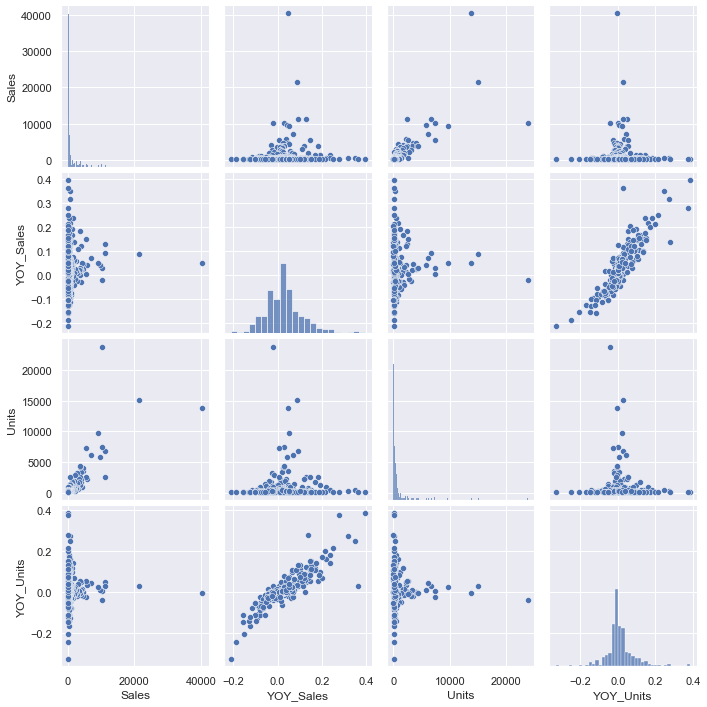

In [20]:
plt.figure(figsize=(12, 12))
sns.pairplot(data=df_processed)

plt.show()

From this plot it can be seen the YOY_Sales and YOY_Units have a positive relationship

#### How many percent of the top 250 restaurants that are in each segment?

c:\users\chris\appdata\local\programs\python\python39\lib\site-packages\pandas\plotting\_matplotlib\core.py:1583: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  results = ax.pie(y, labels=blabels, **kwds)


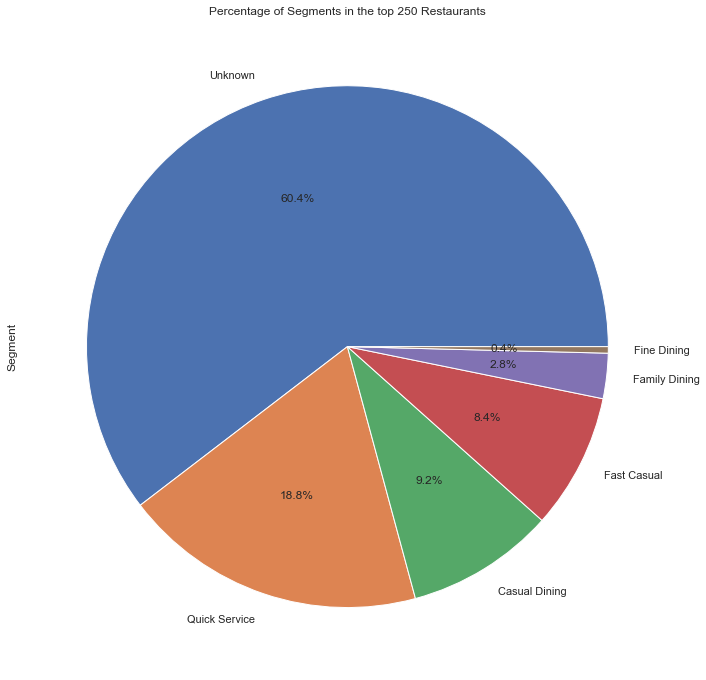

In [21]:
segment_percentage = df_processed['Segment'].value_counts() / df_processed['Segment'].count()
segment_percentage.plot.pie(autopct="%.1f%%", figsize=(12, 12), title="Percentage of Segments in the top 250 Restaurants")
plt.show()

It can be seen in the pie chart that 60.04% of restaurant segments of the data of top 250 restaurants is unknown. 18.8% is quick service, 9.2% is casual dining, 8.4% is fast casual, 2.8% is family dining, and 0.4% is fine dining.

#### What type of food does the restaurant sell the most?

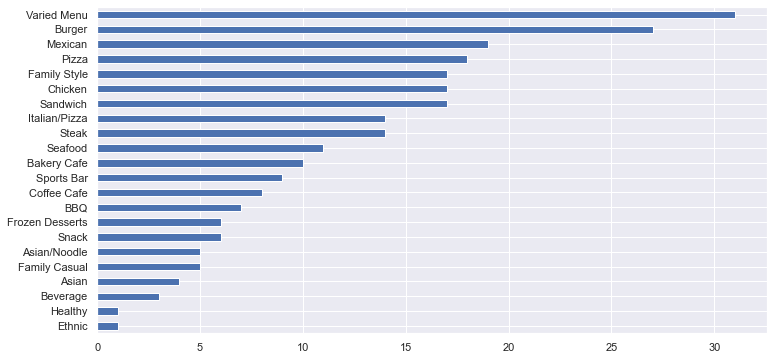

In [22]:
df_processed['Menu_Category'].value_counts().sort_values().plot(kind='barh', figsize=(12, 6))

plt.show()

It can be seen in the chart that most restaurants have a varied menu type

#### Is there are relationship between the units and the number sold?

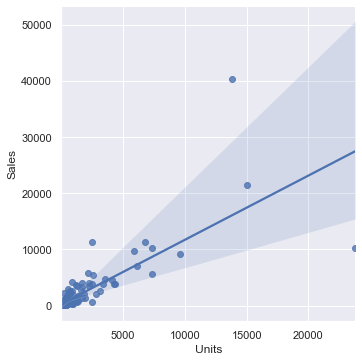

In [23]:
sns.lmplot(x='Units', y='Sales', data=df_processed)
plt.show()

Looking at the plot and its line, it seems that there is a positive relationship between the Units and the Sales where the more Units a restaurant have the higher their Sales are. 

But this does not apply to all.  As can be seen there is a restaurant with more than 20k units but has a lower sale. Which makes sense since there is a lot more factors to make a company profitable such as Advertisements and many more, not just the number of premises alone.

#### Is there are relationship between the improvement in the number of units and the number sold?

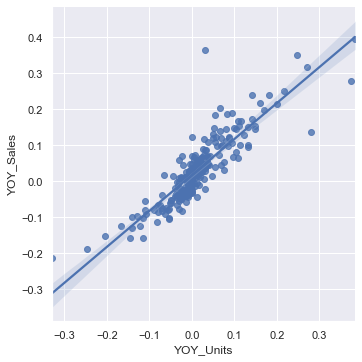

In [24]:
sns.lmplot(x='YOY_Units', y='YOY_Sales', data=df_processed)
plt.show()

In [25]:
pearson_correlation_coefficient = pearsonr(df_processed['YOY_Units'], df_processed['YOY_Sales'])[0]
pearson_correlation_coefficient

0.8832733736393438

From the graph and computed pearson correlation coefficient above, the correlation between YOY_Units and YOY_Sales is strong. Which means as YOY_Units increases, there's a good chance that YOY_Sales would also increase.

#### What restaurant improved the most in terms of sales?

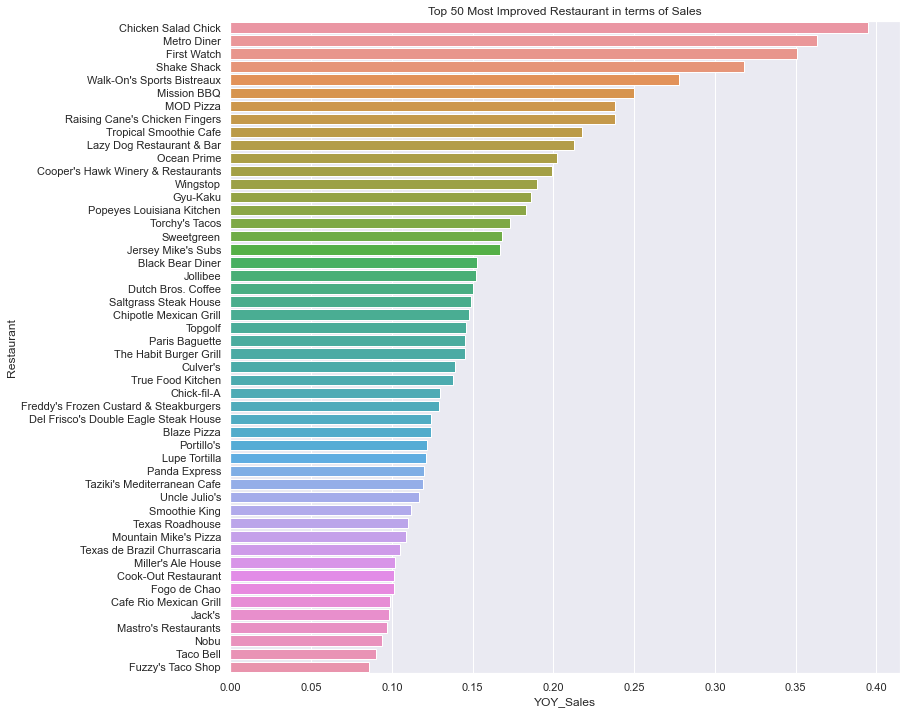

In [26]:
plt.figure(figsize=(12, 12))
plt.title("Top 50 Most Improved Restaurant in terms of Sales")
sns.barplot(x='YOY_Sales', y='Restaurant', data=df_processed.sort_values('YOY_Sales', ascending=False).iloc[:50])

plt.show()

It can be seen that Chicken Salad Chick has the best improvement in Sales. 

#### What restaurant improved the most in terms of units/premises built?

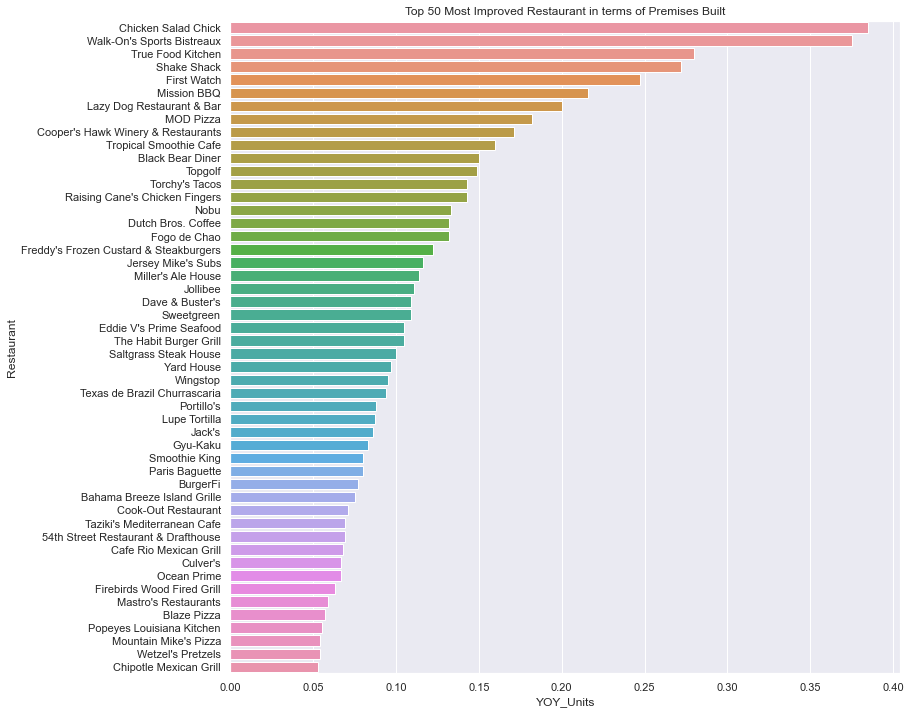

In [27]:
plt.figure(figsize=(12, 12))
plt.title("Top 50 Most Improved Restaurant in terms of Premises Built")
sns.barplot(x='YOY_Units', y='Restaurant', data=df_processed.sort_values('YOY_Units', ascending=False).iloc[:50])

plt.show()

It can be seen that Chicken Salad Chick has the best improvement in Premises Built. 

### Data Visualization

To conclude:

#### 1. MCDonald's had the most sales in for 2019

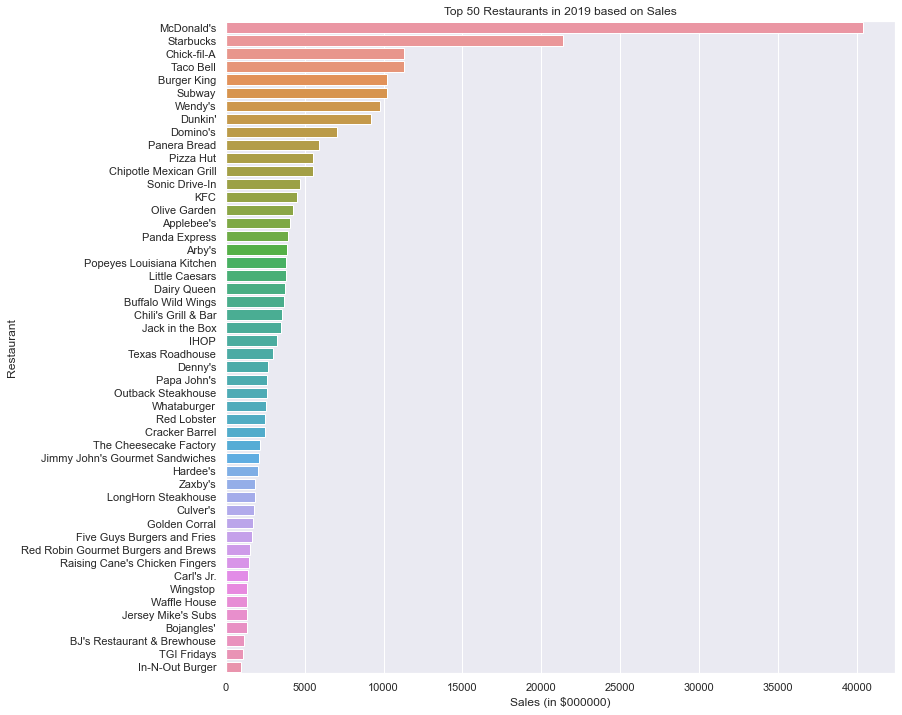

In [28]:
plt.figure(figsize=(12, 12))
plt.title("Top 50 Restaurants in 2019 based on Sales")
sns.barplot(x='Sales', y='Restaurant', data=df_processed.sort_values('Sales', ascending=False).iloc[:50])
plt.xlabel('Sales (in $000000)')

plt.show()

#### 2. Chicken Salad Chick had the best improvement in both Sales and Premises Built (Units owned) in 2019.

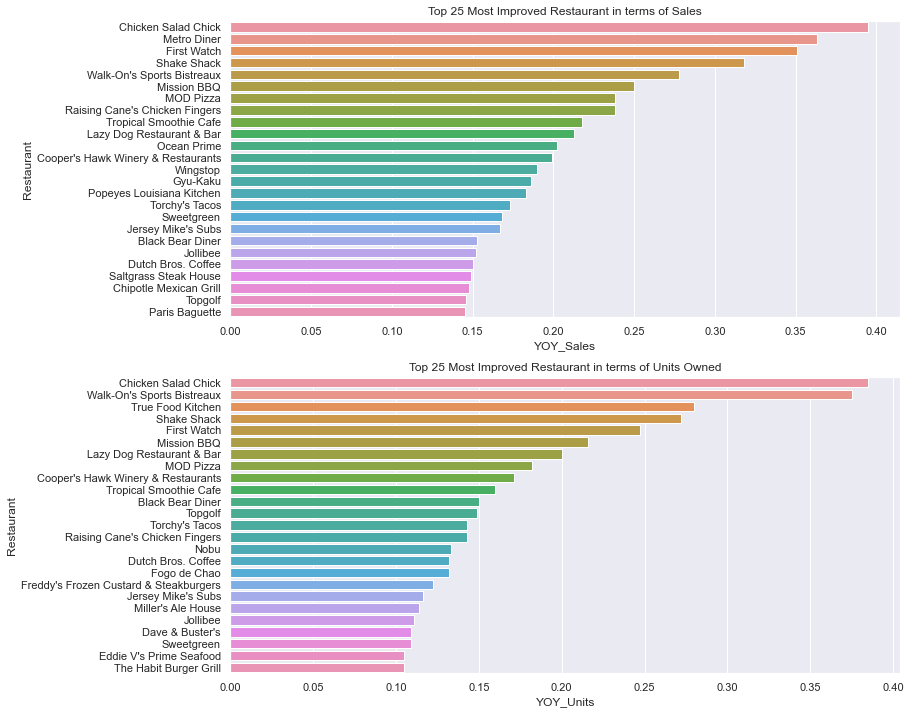

In [29]:
fig, ax = plt.subplots(2,1, figsize=(12, 12))

ax[0].set_title("Top 25 Most Improved Restaurant in terms of Sales")
sns.barplot(x='YOY_Sales', y='Restaurant', data=df_processed.sort_values('YOY_Sales', ascending=False).iloc[:25], ax=ax[0])

ax[1].set_title("Top 25 Most Improved Restaurant in terms of Units Owned")
sns.barplot(x='YOY_Units', y='Restaurant', data=df_processed.sort_values('YOY_Units', ascending=False).iloc[:25], ax=ax[1])

plt.show()

#### 3. Year on Year Units (premises built) and Sales has a strong correlation

Correlation Coefficient: 0.8832733736393437


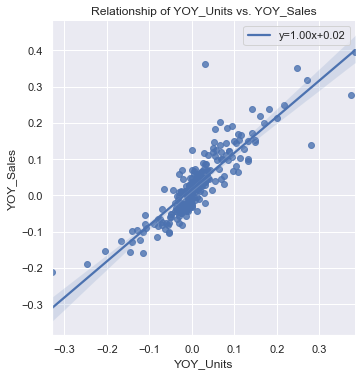

In [30]:
slope, intercept, r_value, p_value, std_err = linregress(df_processed['YOY_Units'], df_processed['YOY_Sales'])
sns.lmplot(x='YOY_Units', y='YOY_Sales', data=df_processed, line_kws={'label':"y=%.2fx+%.2f" % (slope, intercept)})
print('Correlation Coefficient:', r_value)
ax = plt.gca()
ax.set_title('Relationship of YOY_Units vs. YOY_Sales')
plt.legend()
plt.show()

#### 4. Excluding the Unknown Segment, Quick Service / Fast Food Segment has the highest percentage of restaurants in the Top 250 Restaurants of 2019.

c:\users\chris\appdata\local\programs\python\python39\lib\site-packages\pandas\plotting\_matplotlib\core.py:1583: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  results = ax.pie(y, labels=blabels, **kwds)


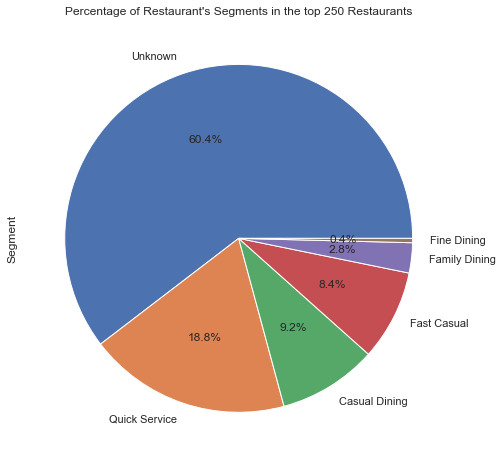

In [31]:
segment_percentage = df_processed['Segment'].value_counts() / df_processed['Segment'].count()
segment_percentage.plot.pie(autopct="%.1f%%", figsize=(8, 8), title="Percentage of Restaurant's Segments in the top 250 Restaurants")
plt.show()

#### 5. The Top 250 Restaurants of 2019 mostly has a Varied Menu, and Burger Menu Type.

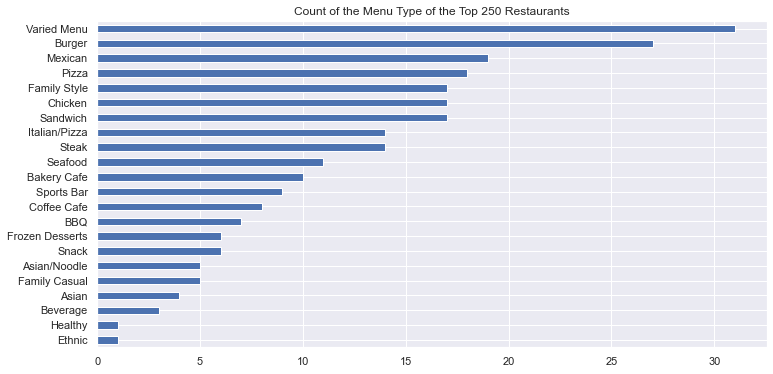

In [32]:
df_processed['Menu_Category'].value_counts().sort_values().plot(kind='barh', figsize=(12, 6), title='Count of the Menu Type of the Top 250 Restaurants')

plt.show()